In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
import torchvision
from diffusers import StableDiffusionPipeline
from transformers import BlipProcessor, BlipForConditionalGeneration

from model import RidgeRegression
from utils import get_resp_transform

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_dir = os.path.join(os.environ["DATA_PATH"], "brainreader", "data")

In [3]:
input_dim = 9395
output_dim = (4, 64, 64)

model = RidgeRegression(input_dim, output_dim, lambda_reg=1).to(device)
model.load_state_dict(torch.load("model_-6.pth", weights_only=True))
model.eval()

RidgeRegression(
  (linear): Linear(in_features=9395, out_features=16384, bias=True)
)

In [4]:
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"


pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

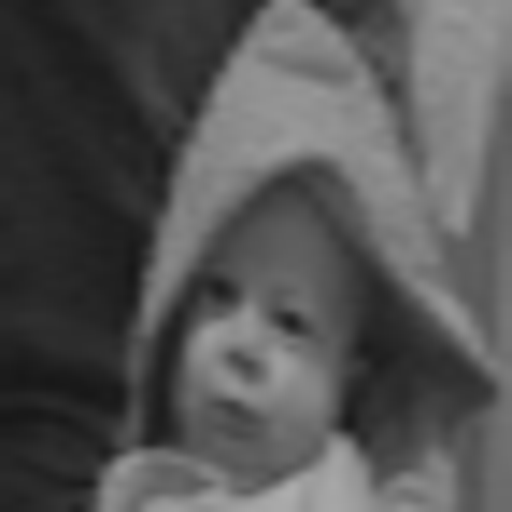

In [5]:
f_name = "datum.pickle"
with open(f_name, "rb") as f:
  data = pickle.load(f)
  vals_to_return = [data["stim"], data["resp"]]

img = torchvision.transforms.functional.to_pil_image(vals_to_return[0]).resize((36, 64)).resize((512, 512))
display(img)

In [6]:
resp_transform = get_resp_transform(dataset_dir, device)

In [7]:
inputs = resp_transform(vals_to_return[1])
inputs.shape

torch.Size([1, 9395])

In [8]:
with torch.no_grad():
    outputs = model(inputs)
outputs.shape

torch.Size([1, 4, 64, 64])

In [9]:
def latents_to_pil(latents):
    # reverse scaling
    latents = (1/0.18215) * latents
    with torch.no_grad():
        # decode sample
        image = pipe.vae.decode(latents).sample
    
    # normalize, shift from -1 and 1 to 0 to 1 and clamp values in that range
    image = (image / 2 + 0.5).clamp(0, 1)
    
    # permute used to convert tensor to image, with channels as last dimension
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    
    # convert to format expected by PIL images (scale to 255, round, convert to unsigned 8 bit integers)
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images 

In [10]:
display(latents_to_pil(outputs.to(dtype=torch.float16))[0])

OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 3.71 GiB of which 84.38 MiB is free. Including non-PyTorch memory, this process has 3.61 GiB memory in use. Of the allocated memory 3.38 GiB is allocated by PyTorch, and 134.88 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)